In [1]:
import sys
import os
#sys.path.insert(0, os.path.abspath('..'))
#sys.path.insert(1, '/path/to/application/app/folder')
sys.path.append('./../sysid_pem_toolbox')

In [2]:
import sysid_pem as sid
import numpy as np
import scipy as sp
import control as ct
import matplotlib.pyplot as plt

In [3]:
def generate_data(B0,C0,D0,F0,N):
    u = np.random.randn(N)
    e = np.random.randn(N)

    H0 = ct.tf(C0,D0,True)
    tt,v = ct.forced_response(H0,U=e)
    G0 = ct.tf(B0,F0,True)
    tt,y = ct.forced_response(G0,U=u)
    
    y = y + 0.1*v
    return u, y

In [4]:
# Code for data generating system 

F0 = np.real(np.convolve([1, -0.2+0.8j],np.convolve([1, -0.2-0.8j],np.convolve([1, -0.6+0.7j],[1, -0.6-0.7j]))))
B0 = np.real(np.convolve([1, -0.7+0.2j],[1, -0.7-0.2j]))
    
C0 = np.real(np.convolve([1, 0.1+0.9j],[1, 0.1-0.9j]))
D0 = np.real(np.convolve([1, -0.5+0.75j],[1, -0.5-0.75j]))
 
G0 = ct.tf(B0,F0,True)
H0 = ct.tf(C0,D0,True)
print('Data Generating System:')
print(G0)
print(H0)

N = 1001
t = np.linspace(0,5,N)
Ts = t[1]-t[0]
fs = 1/Ts 

u,y = generate_data(B0,C0,D0,F0,N)

# make plots of the input and output.

Data Generating System:

            z^2 - 1.4 z + 0.53
------------------------------------------
z^4 - 1.6 z^3 + 2.01 z^2 - 1.156 z + 0.578


z^2 + 0.2 z + 0.82
------------------
 z^2 - z + 0.8125



In [6]:
nf = 4
nb = 3
nc = 2
nd = 2
na = nf
nk = 2
n_arx = [na, nb, nk]
n_bj = [nb, nc, nd, nf, nk]

n_high_order = [30,30,nk]

num_iter = 100
poles_box_jenkins = np.empty((num_iter,nf),dtype=complex)
V_opt_box_jenkins = np.empty(num_iter)
for ii in range(num_iter):
    print('Iteration:',ii)
    u,y = generate_data(B0,C0,D0,F0,N)
   
    theta_init_bj = sid.get_initial_estimate_box_jenkins(n_bj,n_high_order,y,u) 
    optimization_results_bj = sp.optimize.least_squares(sid.V_box_jenkins, theta_init_bj, jac=sid.jac_V_bj, args=(n_bj,y,u))

    poles_box_jenkins[ii,:] = np.roots(np.concatenate(([1],optimization_results_bj.x[n_bj[0]+n_bj[1]+n_bj[2]:n_bj[0]+n_bj[1]+n_bj[2]+n_bj[3]])))
    V_opt_box_jenkins[ii] = np.sum(optimization_results_bj.fun**2)







Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Iteration: 54
Iteration: 55
Iteration: 56
Iteration: 57
Iteration: 58
Iteration: 59
Iteration: 60
Iteration: 61
Iteration: 62
Iteration: 63
Iteration: 64
Iteration: 65
Iteration: 66
Iteration: 67
Iteration: 68
Iteration: 69
Iteration: 70
Iteration: 71
It

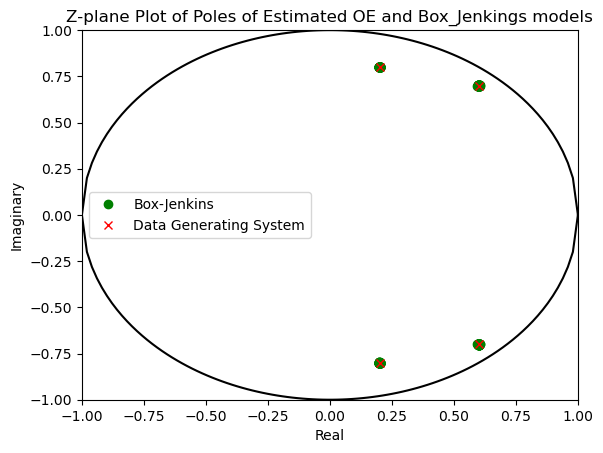

In [9]:
# It would be great if they superimposed the results of the BJ and OE models on the same plot. 
# But for full points, they only need to plot the results fo the Box-Jenkins model in this question.

fig,ax = plt.subplots(1)

for ii in range(num_iter):
    if not np.isnan(V_opt_box_jenkins[ii]):
        if ii == 0:
            ax.plot(np.real(poles_box_jenkins[ii,:]), np.imag(poles_box_jenkins[ii,:]), 'go', label='Box-Jenkins')
        else:
            ax.plot(np.real(poles_box_jenkins[ii,:]), np.imag(poles_box_jenkins[ii,:]), 'go', label=None)


ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
xc = np.linspace(-1,1,100)
yc = np.sqrt(1-xc**2)
ax.plot(xc,yc,'k')
ax.plot(xc,-yc,'k')

# plot plots of data generating system (this is not required, but will help with the next question)
ax.plot(0.2,0.8,'rx',label='Data Generating System')
ax.plot(0.2,-0.8,'rx')
ax.plot(0.6,0.7,'rx')
ax.plot(0.6,-0.7,'rx')

ax.set_title('Z-plane Plot of Poles of Estimated OE and Box_Jenkings models')
ax.set_ylabel('Imaginary')
ax.set_xlabel('Real')
ax.legend()

# -0.5 points if they did not put any titles/labels 
# It is OK if they did not draw the unit circle. It is also OK if they did not include the poles 
# of the data generating system
# There should be 4 clusters in the plot, each cluster around the poles of the data generating system. 
# There will be a few sporadic points due to the optimization getting stuck in local minima. 


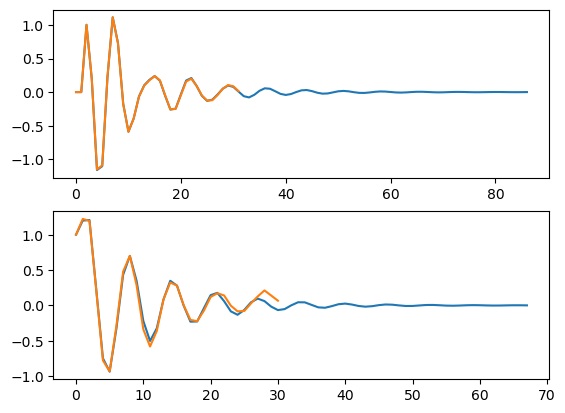

In [6]:
n_high_order = [30,30,2]
ghi,hhi=sid.FIR_estimates_GH(n_high_order,y,u)

tt,g0 = ct.impulse_response(G0)
tt,h0 = ct.impulse_response(H0)
fig,ax = plt.subplots(2,1)
ax[0].plot(g0)
ax[0].plot(ghi)
ax[1].plot(h0)
ax[1].plot(hhi)


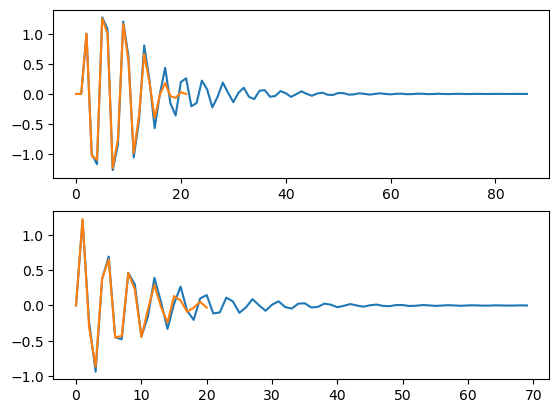

In [20]:
na = 20
nb = 20
nk = 2
n_ho=[na,nb,nk]

theta = sid.V_arx_lin_reg(n_ho,y,u)

A = -theta[0:n_ho[0]]
B = theta[n_ho[0]:n_ho[0]+n_ho[1]]

tt,hig = ct.impulse_response(G0/H0)
tt,hi = ct.impulse_response(1/H0)

fig,ax = plt.subplots(2,1)
ax[0].plot(hig)
ax[0].plot(np.concatenate((np.zeros(nk),B)))
ax[1].plot(np.concatenate((np.zeros(1),-hi[1:-1])))
ax[1].plot(np.concatenate((np.zeros(1),A)))


In [21]:
ng = 30
nh = 30

rB = np.zeros(nh)
cB = np.concatenate(([0],B,np.zeros(ng-nb-1)))

rA = np.concatenate(([1], np.zeros(nh-1)))
cA = np.concatenate(([1], -A, np.zeros(nh-na-1)))

CB = sp.linalg.toeplitz(cB,r=rB)
CA = sp.linalg.toeplitz(cA,r=rA)

M = np.block([[np.eye(ng), -CB],[np.zeros((nh,ng)), CA]])
V = np.concatenate((B,np.zeros(ng-nb),A,np.zeros(nh-na)))
    
theta_gh = np.linalg.inv( M.T @ M ) @ (M.T @ V)

ghi = np.concatenate((np.zeros(nk), theta_gh[0:ng]))
hhi = np.concatenate(([1], theta_gh[ng:ng+nh]))

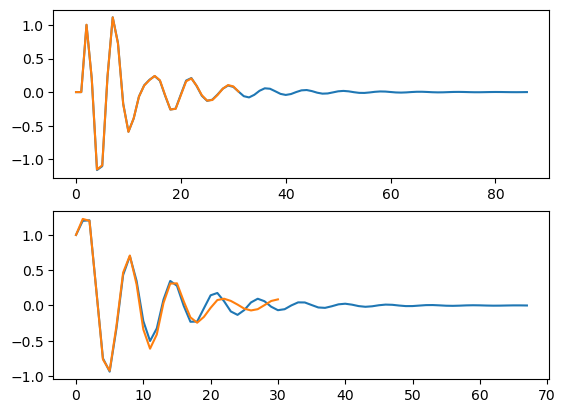

In [22]:
fig,ax = plt.subplots(2,1)
ax[0].plot(g0)
ax[0].plot(ghi)
ax[1].plot(h0)
ax[1].plot(hhi)

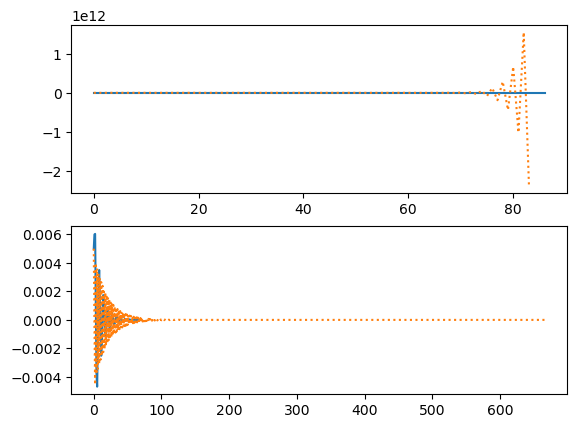

In [23]:
theta = sid.tf_realization_GH(ghi,hhi,n_bj)
Gest,Hest = sid.theta_2_tf_box_jenkins(theta,n_bj,1)

tt,gest = ct.impulse_response(Gest)
tt,hest = ct.impulse_response(Hest)

fig,ax=plt.subplots(2,1)
ax[0].plot(g0*Ts)
ax[0].plot(gest*Ts,':')

ax[1].plot(h0*Ts)
ax[1].plot(hest*Ts,':')

In [26]:
print(theta)
print(Gest)
print(Gest.poles())
print(G0)

[ 1.00272778 -1.10073267  0.16350449  0.77976018 -1.06371575  0.88554396
 -0.06067643  0.01260991 -1.30251896  1.22489871 -0.45689092]

          1.003 z^4 - 1.101 z^3 + 0.1635 z^2
------------------------------------------------------
z^6 + 0.01261 z^5 - 1.303 z^4 + 1.225 z^3 - 0.4569 z^2

dt = 1

[-1.52389978+0.j          0.69134769+0.j          0.40997109+0.51535805j
  0.40997109-0.51535805j  0.        +0.j          0.        +0.j        ]

            z^2 - 1.4 z + 0.53
------------------------------------------
z^4 - 1.6 z^3 + 2.01 z^2 - 1.156 z + 0.578



In [32]:
g = ghi
h = hhi
na = 4
nb = 3
nc = 2
nd = 2

ng = 30
nh = 30

Cg = np.array(sp.linalg.toeplitz(np.concatenate(([0],g[nk:nk+ng-1])),r=np.zeros(na)))
Meye = np.concatenate((np.eye(nb), np.zeros((ng-nb,nb))),axis=0)
M = np.concatenate((Meye,-Cg),axis=1)
thetaBA = np.linalg.inv( M.T @ M ) @ (M.T @ g[nk:ng+nk] )

Ch = np.array(sp.linalg.toeplitz(h[0:nh],r=np.concatenate(([1],np.zeros(nd-1)))))
Meye = np.concatenate((np.eye(nc), np.zeros((nh-nc,nc))),axis=0)
M = np.concatenate((Meye,-Ch),axis=1)
thetaCD = np.linalg.inv( M.T @ M ) @ (M.T @ h[1:nh+1] )

theta = np.concatenate((thetaBA[0:nb], thetaCD, thetaBA[nb:nb+na]))


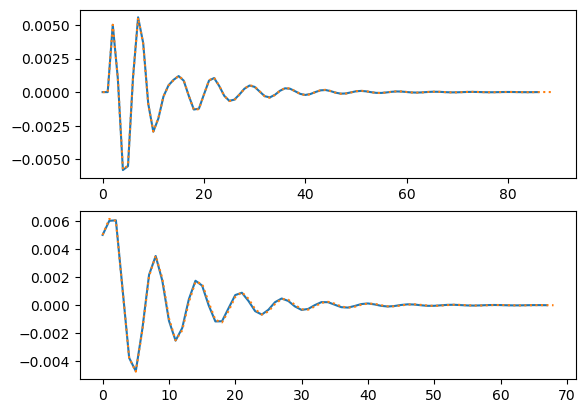

In [33]:
Gest,Hest = sid.theta_2_tf_box_jenkins(theta,[nb,nc,nd,na,nk],1)


tt,gest = ct.impulse_response(Gest)
tt,hest = ct.impulse_response(Hest)

fig,ax=plt.subplots(2,1)
ax[0].plot(g0*Ts)
ax[0].plot(gest*Ts,':')

ax[1].plot(h0*Ts)
ax[1].plot(hest*Ts,':')

In [16]:
print(M.shape)
print(M)

(30, 7)
[[ 1.          0.          0.         -0.         -0.         -0.
  -0.        ]
 [ 0.          1.          0.         -1.00261581 -0.         -0.
  -0.        ]
 [ 0.          0.          1.         -0.20581452 -1.00261581 -0.
  -0.        ]
 [ 0.          0.          0.          1.15061663 -0.20581452 -1.00261581
  -0.        ]
 [ 0.          0.          0.          1.09016831  1.15061663 -0.20581452
  -1.00261581]
 [ 0.          0.          0.         -0.22822564  1.09016831  1.15061663
  -0.20581452]
 [ 0.          0.          0.         -1.11269109 -0.22822564  1.09016831
   1.15061663]
 [ 0.          0.          0.         -0.72424646 -1.11269109 -0.22822564
   1.09016831]
 [ 0.          0.          0.          0.17864761 -0.72424646 -1.11269109
  -0.22822564]
 [ 0.          0.          0.          0.59052923  0.17864761 -0.72424646
  -1.11269109]
 [ 0.          0.          0.          0.3912785   0.59052923  0.17864761
  -0.72424646]
 [ 0.          0.          0.        

In [19]:
print(g[0:10])
print(g[nk])
print(thetaBA)

[ 0.          0.          1.00261581  0.20581452 -1.15061663 -1.09016831
  0.22822564  1.11269109  0.72424646 -0.17864761]
1.002615814710943
[ 1.00261581 -1.40265506  0.54418492 -1.60427309  2.01970108 -1.16500596
  0.58424452]
